In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Loading Dataset

In [2]:
heart = pd.read_csv("heart.csv")

In [3]:
heart.shape

(303, 14)

## Preprocessing

In [4]:
heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
print("This dataset contains %d null values" % heart.isna().sum().sum())
print("These are the target classes:", heart.target.unique())

This dataset contains 0 null values
These are the target classes: [1 0]


This means that the target is a categorical variable which takes only two values: **1 or 0**, translating to either the patience has a *heart desease* or not.

In [6]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


## Visualization

<Figure size 1080x1080 with 0 Axes>

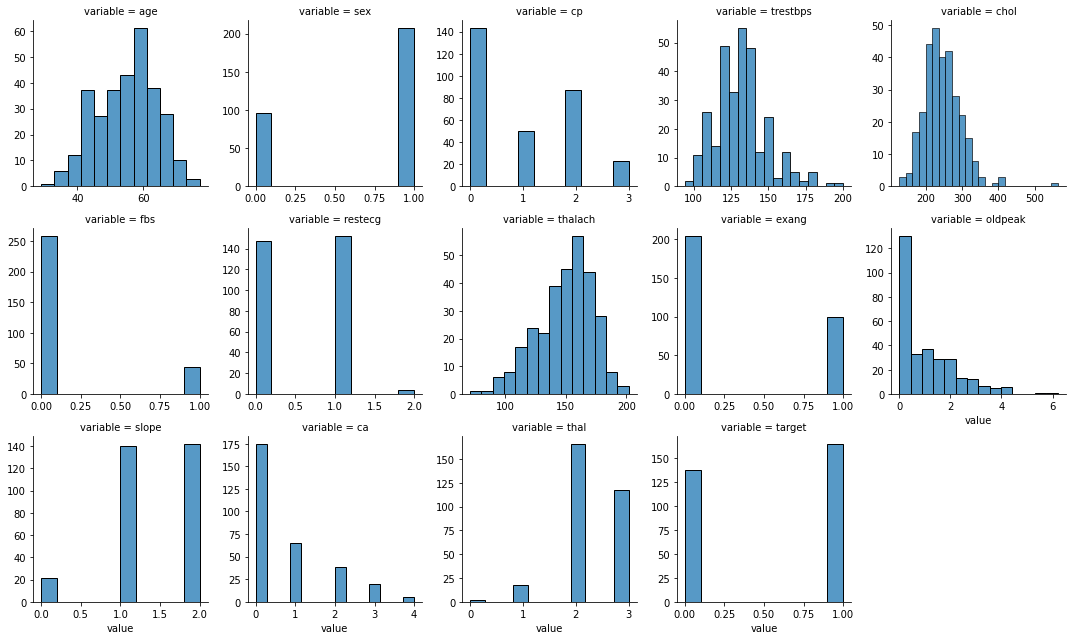

In [7]:
plt.figure(figsize=(15,15))
f = pd.melt(heart)
facet = sns.FacetGrid(f, col_wrap=5, col="variable", sharex=False, sharey=False)
facet = facet.map(sns.histplot, "value", kde=False)
plt.show()

from the description of the dataset and the histograms above,we conclude that the following variables are categorical as well as the target:
- cp: Chest Pain
- ca: Number of Major Vessels
- fbs: Fasting Blood Sugar
- restecg: Resting Electrocardiographic Results
- exang: Exercise Induced Angina
- thal: Thalasemia, a blood disorder

### Correlation

In [8]:
def plot_correlation_map( df , method="pearson"):
    corr = df.corr(method=method)
    s , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 10 , 220 , as_cmap = True )

    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    s = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 },
        mask=mask
        )

Since there are plenty of categorical variables, it's preferable to use *Spearman Correlation* to calculate the correlation between the features.

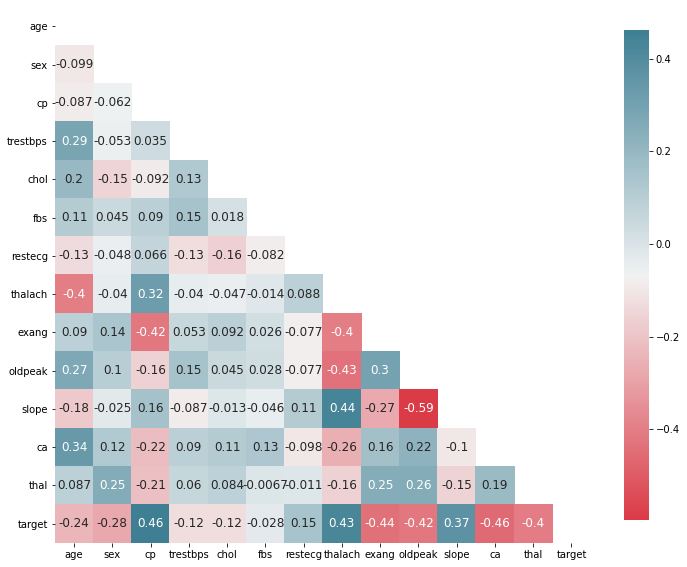

In [9]:
plot_correlation_map(heart, method="spearman")

We notice that the *Chest Pain (cp)* is the most correlated feature with our target.

To test this even further, let's perform a **Chi-Square** test of independence between *target* and *cp* to confirm the previous assumption.

#### Chi-square Test of Independence (Target vs CP)

We start by creating the contingency table

In [10]:
import scipy.stats as st

data = pd.crosstab(heart.target, heart.cp, margins=True)
data

cp,0,1,2,3,All
target,,,,,
0,104,9,18,7,138
1,39,41,69,16,165
All,143,50,87,23,303


Now, we have two hypothesis:
1. **H0:** cp and target are independent and cp doesn't impact the target.
2. **Ha:** target is dependent on cp
We shall base our conclusion of the resuls of the **p-value**. If it's smaller than the threshold **alpha (=0.05)** then we reject the null *hypothesis (H0)* and accept the *alternative one (Ha)*

In [11]:
st.chi2_contingency(data)

(81.68642755194445,
 2.236128842704974e-14,
 8,
 array([[ 65.12871287,  22.77227723,  39.62376238,  10.47524752,
         138.        ],
        [ 77.87128713,  27.22772277,  47.37623762,  12.52475248,
         165.        ],
        [143.        ,  50.        ,  87.        ,  23.        ,
         303.        ]]))

Since the *p-value (2.236e-14) < alpha (0.05)* we reject the null hypothesis and accept the alternative hypothesis. This means that the Chest Pain (cp) has an impact on wether the patient has a haeart disease or not, which in turn confirms the results of the previous correlation matrix.

### More Visualization

# Modeling

## Part 1: Using the dataset as it is

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics


In [13]:
SEED = 40
X_train, X_test, Y_train, Y_test = train_test_split(heart.drop("target", axis=1), heart.target, test_size=0.30, random_state=SEED)

### Logistic Regression

In [14]:
LR = LogisticRegression(penalty="l2", n_jobs=-1, random_state=SEED)
LR.fit(X_train, Y_train)
Y_pred = LR.predict(X_test)

print("Logistic Regression Classifier accuracy: ", np.round(metrics.accuracy_score(Y_test, Y_pred),3))

Logistic Regression Classifier accuracy:  0.912


### Random Forest

In [15]:
RFC = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=4, bootstrap=True, random_state=SEED)
RFC.fit(X_train, Y_train)
Y_pred = RFC.predict(X_test)

print("Random Forest Classifier accuracy: ", np.round(metrics.accuracy_score(Y_test, Y_pred),3))


Random Forest Classifier accuracy:  0.901


### Voting Classifier (Using a mixture of the above algorithms)

In [16]:
VC = VotingClassifier(estimators=[("LR", LR), ("RFC", RFC)], voting="soft")

VC.fit(X_train, Y_train)
Y_pred = VC.predict(X_test)

print( "Voting Classifier Accuracy using soft voting strategy : " + str(np.round(metrics.accuracy_score(Y_test,Y_pred),3)))

Voting Classifier Accuracy using soft voting strategy : 0.923


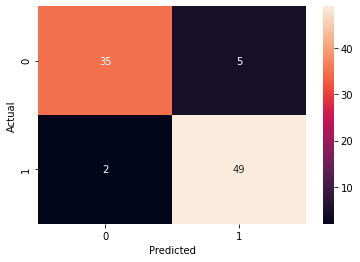

In [17]:
confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [18]:
print("f1 Score={:.2f}".format(metrics.f1_score(Y_test, Y_pred, average="binary")))

f1 Score=0.93


In [19]:
TP, TN, FP, FN = confusion_matrix.loc[1][1], confusion_matrix.loc[0][0], confusion_matrix.loc[0][1], confusion_matrix.loc[1][0]
recall = TP/(TP + FN)
precision = TP/(TP + FP)
print("Recall = %.2f\nPrecision: %.2f" % (recall, precision))
print(f"f1 score: {metrics.fbeta_score(Y_test, Y_pred, beta=1):.2f}")
print(f"f2 score: {metrics.fbeta_score(Y_test, Y_pred, beta=2):.2f}  #giving Recall more weight yields this result.")

Recall = 0.96
Precision: 0.91
f1 score: 0.93
f2 score: 0.95  #giving Recall more weight yields this result.


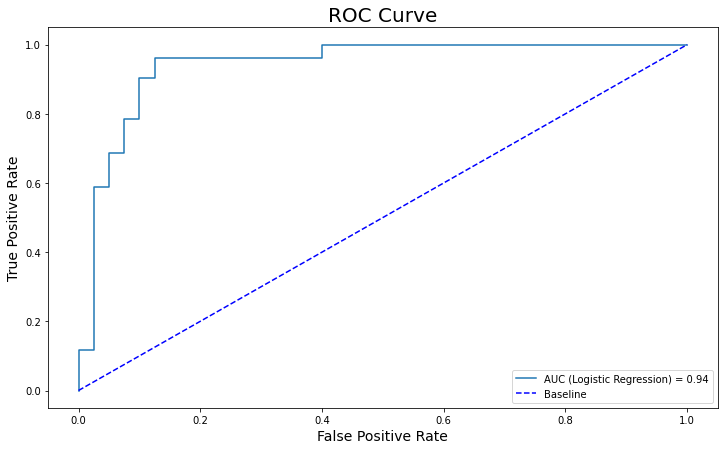

In [20]:
from sklearn.metrics import roc_auc_score, roc_curve

probs_lr = VC.predict_proba(X_test)[:, 1]

auc_lr = roc_auc_score(Y_test, probs_lr)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(Y_test, probs_lr)

plt.figure(figsize=(12, 7))

plt.plot(fpr_lr, tpr_lr, label=f'AUC (Logistic Regression) = {auc_lr:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('ROC Curve', size=20)
plt.xlabel('False Positive Rate', size=14)
plt.ylabel('True Positive Rate', size=14)
plt.legend()
plt.show()

The model makes a 94 correct predidctions out of 100. <br>
Although we have a 96% recall, the precision is low (91%), we need to maximize that.

## Part 2: Preprocessing the dataset before modeling

Since out dataset contains multiple categorical/ numerical features, we are going to seperate them, then rescale the numerical features.

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_features = ["age", "trestbps", "chol", "thalach", "oldpeak"]
data = scaler.fit_transform(heart[numerical_features])

data = pd.DataFrame(data, columns=numerical_features).join(heart.drop(numerical_features, axis=1), how="left")
data

,age,trestbps,chol,thalach,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal,target
0,0.952197,0.763956,-0.256334,0.015443,1.087338,1,3,1,0,0,0,0,1,1
1,-1.915313,-0.092738,0.072199,1.633471,2.122573,1,2,0,1,0,0,0,2,1
2,-1.474158,-0.092738,-0.816773,0.977514,0.310912,0,1,0,0,0,2,0,2,1
3,0.180175,-0.663867,-0.198357,1.239897,-0.206705,1,1,0,1,0,2,0,2,1
4,0.290464,-0.663867,2.082050,0.583939,-0.379244,0,0,0,1,1,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,0.290464,0.478391,-0.101730,-1.165281,-0.724323,0,0,0,1,1,1,0,3,0
299,-1.033002,-1.234996,0.342756,-0.771706,0.138373,1,3,0,1,0,1,0,3,0
300,1.503641,0.706843,-1.029353,-0.378132,2.036303,1,0,1,1,0,1,2,3,0
301,0.290464,-0.092738,-2.227533,-1.515125,0.138373,1,0,0,1,1,1,1,3,0


In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(data.drop("target", axis=1), data.target, test_size=0.30, random_state=SEED)

VC2 = VotingClassifier(estimators=[("RFC", RFC), ("LR", LR)], voting="soft", n_jobs=-1)

VC2.fit(X_train, Y_train)
Y_pred = VC2.predict(X_test)

print( "Voting Classifier Accuracy using soft strategy : " + str(np.round(metrics.accuracy_score(Y_test,Y_pred),3)))

Voting Classifier Accuracy using soft strategy : 0.923


In [26]:
LR.fit(X_train, Y_train)
Y_pred = LR.predict(X_test)
print( "Accuracy : " + str(np.round(metrics.accuracy_score(Y_test,Y_pred),3)))

Accuracy : 0.923


In [27]:
RFC.fit(X_train, Y_train)
Y_pred = RFC.predict(X_test)
print( "Accuracy : " + str(np.round(metrics.accuracy_score(Y_test,Y_pred),3)))

Accuracy : 0.89


Transforming the data didn't yield better results. In fact, we get the same results using only **Logistic Regression** compared to when using **Voting Classifer**.